In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# Här är importen som saknades i din körning:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog

print("Alla bibliotek är inladdade!")

Alla bibliotek är inladdade!


In [16]:
print("1. Hämtar MNIST-data...")
X, y = fetch_openml('mnist_784', version=1, as_frame=False, return_X_y=True)
X = X / 255.0

# Först bryter vi ut 15% till Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Sedan delar vi resterande 85% i Träning och Validering (ca 15% av totalen blir validering)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

print(f"📊 Uppdelning klar:")
print(f"Träning: {X_train.shape[0]} | Validering: {X_val.shape[0]} | Test: {X_test.shape[0]}")

1. Hämtar MNIST-data...
📊 Uppdelning klar:
Träning: 48998 | Validering: 10502 | Test: 10500


In [17]:
print("2. Extraherar HOG-features...")

def extract_features(data):
    return np.array([hog(img.reshape(28, 28), orientations=9, 
                         pixels_per_cell=(8, 8), cells_per_block=(2, 2)) for img in data])

X_train_hog = extract_features(X_train)
X_val_hog = extract_features(X_val)
X_test_hog = extract_features(X_test)

print("✅ HOG-features extraherade för alla set.")

2. Extraherar HOG-features...
✅ HOG-features extraherade för alla set.


In [18]:
print("3. Skalar och tränar modellen...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_val_scaled = scaler.transform(X_val_hog)
X_test_scaled = scaler.transform(X_test_hog)

clf = LinearSVC(C=1.0, max_iter=10000, dual=False)
clf.fit(X_train_scaled, y_train)

# Kontroll mot Valideringsdata
val_preds = clf.predict(X_val_scaled)
print(f"🎯 Validerings-accuracy: {accuracy_score(y_val, val_preds):.4f}")

3. Skalar och tränar modellen...
🎯 Validerings-accuracy: 0.9464


4. Slutgiltig testning...


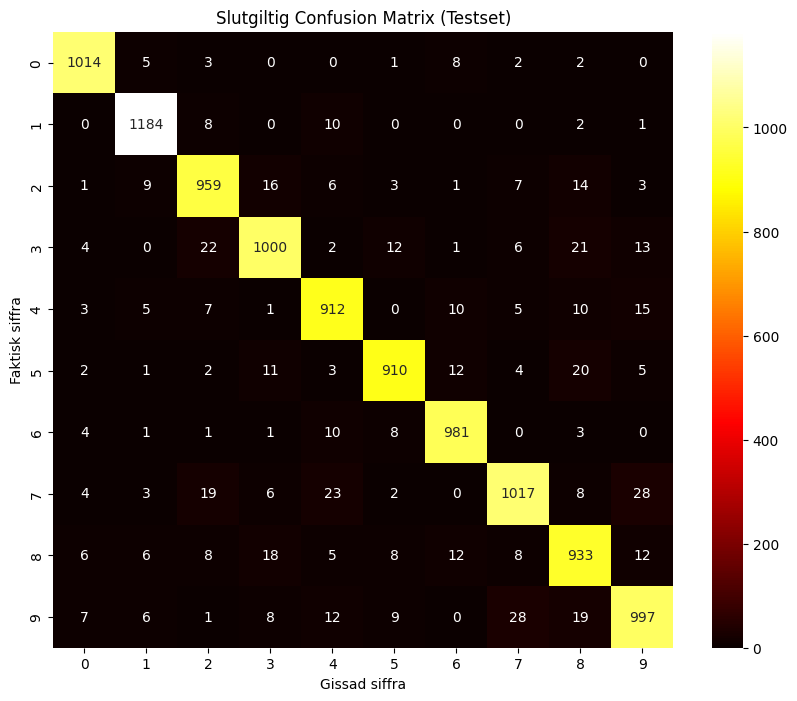

In [19]:
print("4. Slutgiltig testning...")
y_pred = clf.predict(X_test_scaled)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='hot')
plt.title('Slutgiltig Confusion Matrix (Testset)')
plt.ylabel('Faktisk siffra')
plt.xlabel('Gissad siffra')
plt.show()

In [21]:
import os
import joblib

print("5. Sparar filer...")

# Försök 1: Spara i projektmappen (där du är just nu) - Säkraste sättet
try:
    joblib.dump(clf, 'mnist_hog_model.pkl')
    joblib.dump(scaler, 'mnist_scaler.pkl')
    print(f"✅ Klart! Filerna sparades lokalt i projektmappen: {os.getcwd()}")
except Exception as e:
    print(f"Kunde inte spara lokalt: {e}")
    
    # Försök 2: Spara på Skrivbordet (med OneDrive-hantering)
    try:
        # Denna kod letar efter skrivbordet även om det ligger i OneDrive
        desktop = os.path.join(os.environ['USERPROFILE'], 'Desktop')
        if not os.path.exists(desktop):
            desktop = os.path.join(os.environ['USERPROFILE'], 'OneDrive', 'Desktop')
            
        joblib.dump(clf, os.path.join(desktop, 'mnist_hog_model.pkl'))
        joblib.dump(scaler, os.path.join(desktop, 'mnist_scaler.pkl'))
        print(f"✅ Klart! Filerna sparades på skrivbordet: {desktop}")
    except Exception as e2:
        print(f"Kunde inte spara på skrivbordet heller: {e2}")

print("\n--- SLUTGILTIG KLASSIFICERINGSRAPPORT ---")
# Se till att y_test och y_pred finns i minnet
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

5. Sparar filer...
✅ Klart! Filerna sparades lokalt i projektmappen: c:\Utveckling\ML\MNIST_KK2\Kunskapskontroll_2

--- SLUTGILTIG KLASSIFICERINGSRAPPORT ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1035
           1       0.97      0.98      0.98      1205
           2       0.93      0.94      0.94      1019
           3       0.94      0.93      0.93      1081
           4       0.93      0.94      0.93       968
           5       0.95      0.94      0.95       970
           6       0.96      0.97      0.96      1009
           7       0.94      0.92      0.93      1110
           8       0.90      0.92      0.91      1016
           9       0.93      0.92      0.92      1087

    accuracy                           0.94     10500
   macro avg       0.94      0.94      0.94     10500
weighted avg       0.94      0.94      0.94     10500

